https://colab.research.google.com/drive/1_tHUYgO_fIBU1JXdn_mXWCDD6njLyNSu

## AI를 사용한 이미지 생성 

새로운 이미지 생성을 위해 생성적 대립 신경망(GAN)이라고 하는 유명한 생성 모델 사용 

GAN 이전의 신경망 : 이미지를 제한된 차원의 vecto로 인코딩하는 것을 학습한다는 것을 의미 

GAN : Generator Vs Discriminator  
- 예술품 위조범과 판별사의 관계  
- 미술품이 가짜라는 것을 D가 찾아내면 D에게 보상, 
- 모조품을 진짜라고 판별함녀 G에게 보상 

간단한 데이터셋을 사용한 예제로 이 알고리즘의 동작을 알아 보자. 

In [1]:
# tensorflow와 수학 계산 라이브러리 로드 
import tensorflow as tf 
import numpy as np

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# tensorflow 1.0 이상을 권장 
print(tf.__version__)

2.4.1


In [4]:
# 생성할 이미지를 저장할 폴더 생성 
!mkdir images

In [5]:
# keras에서 fashion 데이터셋 로드 
fashion_mnist = tf.keras.datasets.fashion_mnist

In [6]:
# 훈련 및 테스트 데이터 추출 
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
# 이미지들에 대한 분류명 설정 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Anke boot'] ##10가지 분류 레이블
               #첫번째 데이터는 'Anke boot'

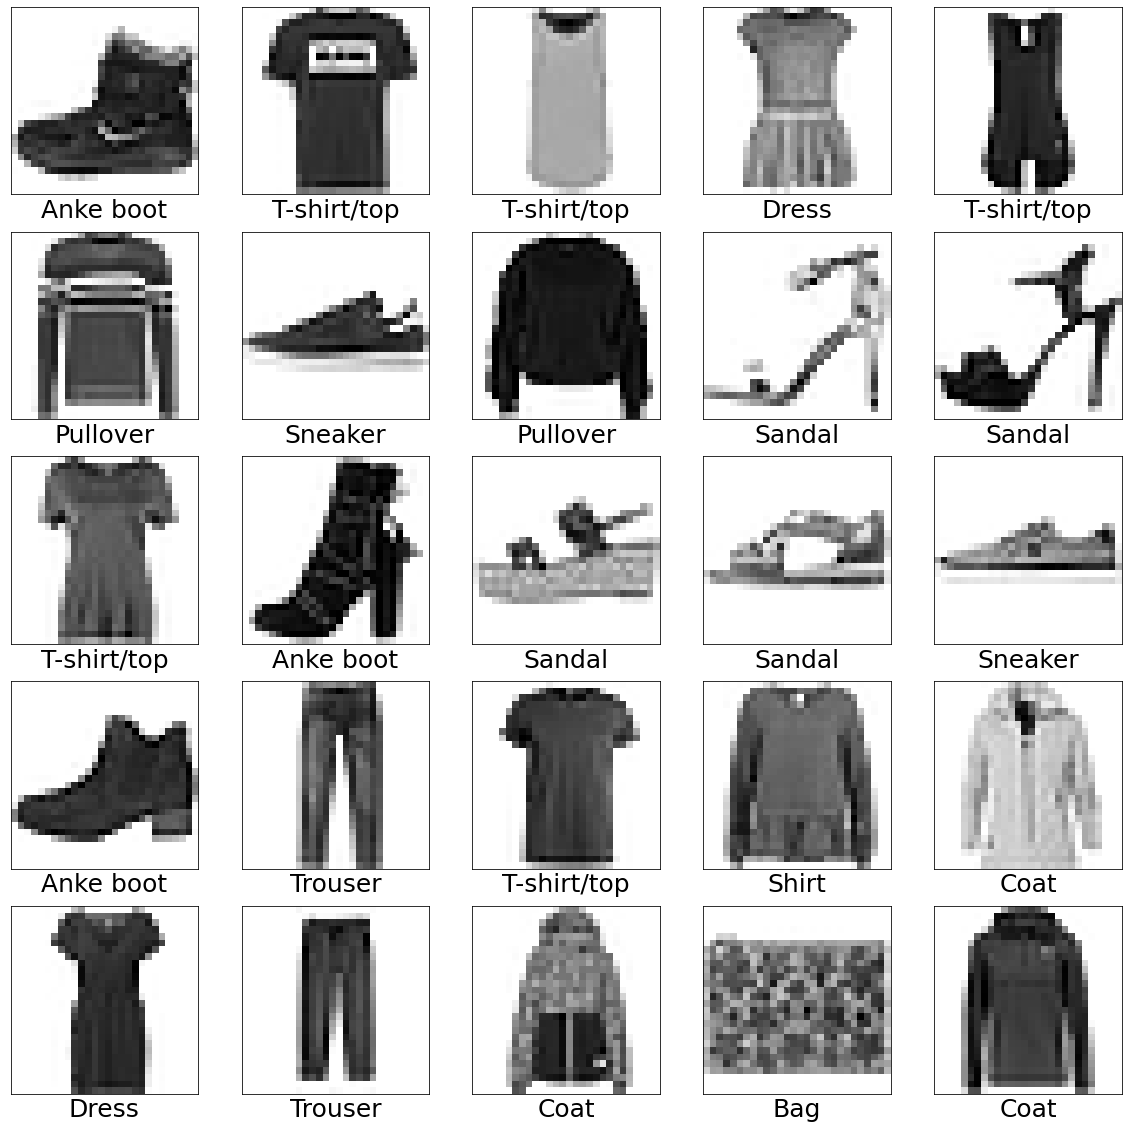

In [9]:
# 처음 25개의 이미지 표현 
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]], fontsize=25)

> **STEP 1:**  
- 두 개의 신경망(생성자G, 판별자D) 구축 
- G : 랜덤 인코딩 벡터를 입력받아 28x28 크기의 이미지 생성 
- D : 28x28 크기의 이미지를 받아서 참/거짓 중 하나의 결과 내준다. 

In [13]:
# 신경망 생성을 위해 keras 라이브러리 로드 
from tensorflow.keras.layers import Input, ReLU, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [14]:
# 인코딩 차원 설정 : 이미지 배열을 128차원 벡터로 변환한다.
ENCODING_SIZE = 128

In [17]:
# 훈련 데이터 정규화 
X_train = x_train.astype(np.float32)/255.

In [18]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [20]:
# 이미지 생성하는 생성자 구축 
generator = Sequential()
generator.add(Dense(
    256, input_dim=ENCODING_SIZE, kernel_initializer='random_uniform' # (100, 128) 크기의 noise 들어올 예정 
))
generator.add(ReLU())
generator.add(Dense(512))
generator.add(ReLU())
generator.add(Dense(1024))
generator.add(ReLU())
generator.add(Dense(784, activation='tanh')) # 28*28=784
generator.compile(loss='binary_crossentropy', optimizer=adam)
print('------ GENERATOR ------')
generator.summary()

------ GENERATOR ------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (

In [21]:
# 이미지를 분류할 판별자 구축 
discriminator = Sequential()
discriminator.add(Dense(
    1024, input_dim=784, kernel_initializer='random_uniform'
)) # kernel_initializer : weight 초기화 방식 
discriminator.add(ReLU())
discriminator.add(Dense(512))
discriminator.add(ReLU())
discriminator.add(Dense(256))
discriminator.add(ReLU())
discriminator.add(Dense(1, activation='sigmoid')) # 이진 분류 
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
print('------ DISCRIMINATION ------')
discriminator.summary()

------ DISCRIMINATION ------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
re_lu_3 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)          

In [23]:
# 두 신경망을 하나의 모델로 결합 
discriminator.trainable=False
ganInput = Input(shape=(ENCODING_SIZE,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan_model = Model(inputs=ganInput, outputs=ganOutput)
gan_model.compile(loss='binary_crossentropy', optimizer=adam)

In [24]:
gan_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1493520   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,953,745
Trainable params: 1,493,520
Non-trainable params: 1,460,225
_________________________________________________________________


> **STEP 2:**  
두 개의 함수를 작성 + 훈련 진행  
- 각 epoch 종료 후 생성된 이미지 보여준다. 

In [28]:
# 배열에 생성된 이미지 그리기 
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    # 이미지 생성을 위한 랜덤 인코딩 벡터 생성 
    noise = np.random.normal(0, 1, size=[examples, ENCODING_SIZE]) # loc: 평균, scale: 표준편차, size, 크기=(100, 128)
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    
    # 이미지 배열 그리기 
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generatedImages[i], cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

# 생성 모델의 훈련 
def train(epochs=1, batchSize=128):
    # batch 내 샘플 수 가져오기 
    batchCount = int(X_train.shape[0] / batchSize)
    print("Epochs: ", epochs)
    print("Batch size: ", batchSize)
    print("Batches per epoch: ", batchCount)
    
    # 각 epoch에 대해서 
    for e in range(1, epochs + 1):
        print("-" * 15, '\nEpoch %d' % e)
        # 각 batch에 대해서 
        for idx in np.arange(0, batchCount):
            if idx % 10 == 0:
                print("-", end='')
                
            # 입력 노이즈와 이미지의 랜덤 집합 구하기 
            noise = np.random.normal(0, 1, size=[batchSize, ENCODING_SIZE])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
            
            # 가짜 패션 아이템 이미지 생성 
            generatedImages = generator.predict(noise)
            imageBatch = np.reshape(imageBatch, (batchSize, 784))
            X = np.concatenate([imageBatch, generatedImages])
            
            # 생성된 데이터와 진짜 데이터에 대한 클래스 레이블 
            yDis = np.zeros(2 * batchSize)
            # one-sided label smoothing 
            yDis[:batchSize] = 0.9
            
            # 판별자 훈련 
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            
            # 생성자 훈련 
            noise = np.random.normal(0, 1, size=[batchSize, ENCODING_SIZE])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan_model.train_on_batch(noise, yGen)
            
        plotGeneratedImages(e, examples=25, dim=(5, 5))

Epochs:  40
Batch size:  128
Batches per epoch:  468
--------------- 
Epoch 1
-----------------------------------------------

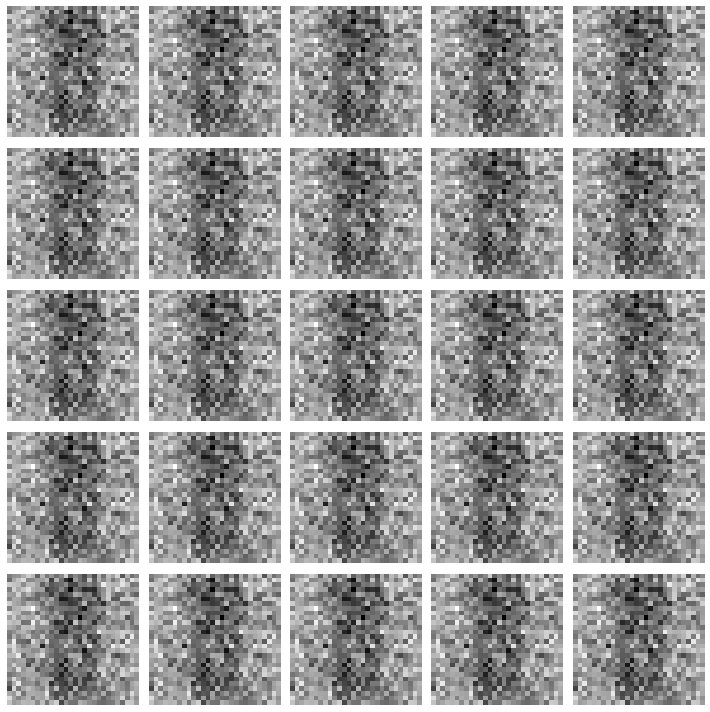

--------------- 
Epoch 2
-----------------------------------------------

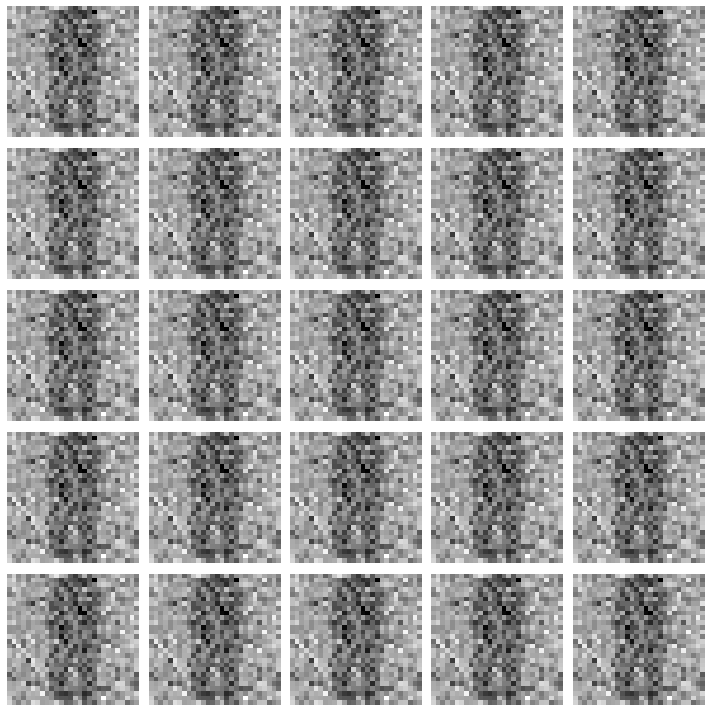

--------------- 
Epoch 3
-----------------------------------------------

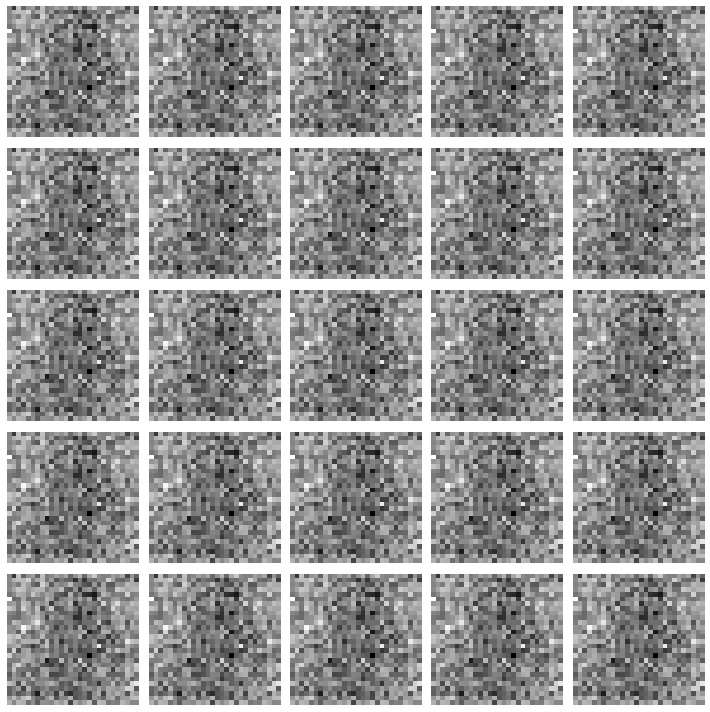

--------------- 
Epoch 4
-----------------------------------------------

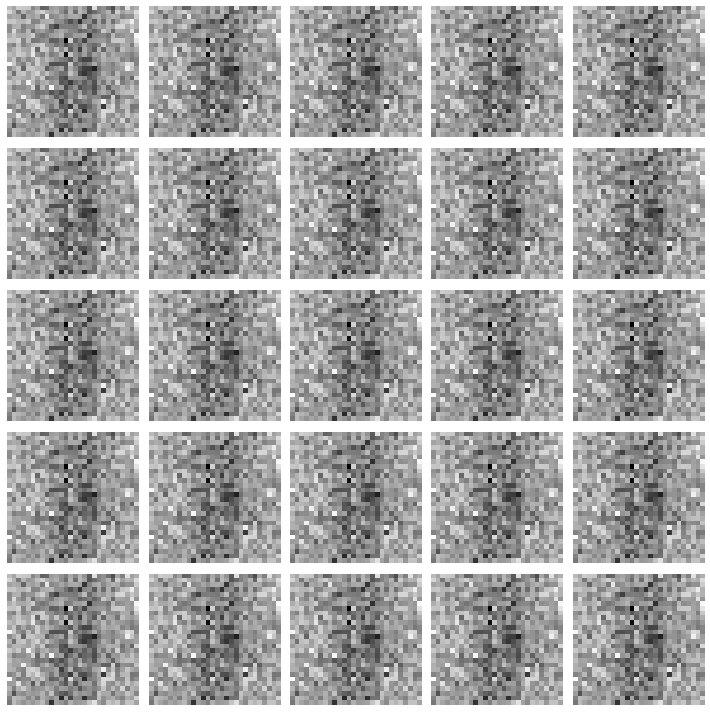

--------------- 
Epoch 5
-----------------------------------------------

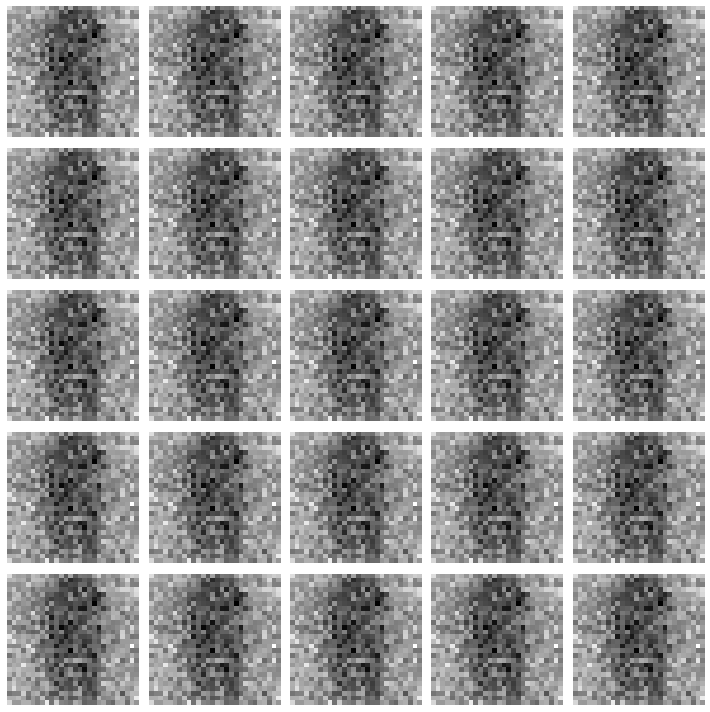

--------------- 
Epoch 6
-----------------------------------------------

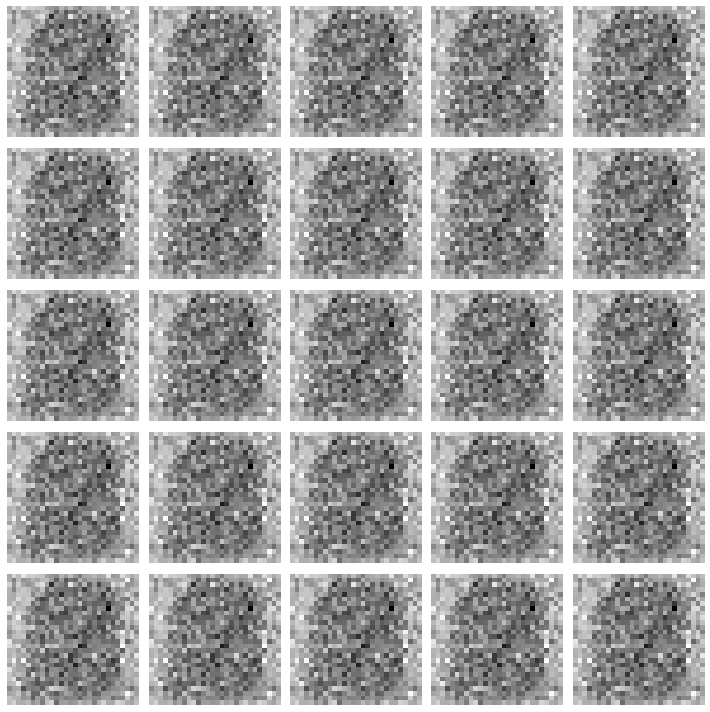

--------------- 
Epoch 7
-----------------------------------------------

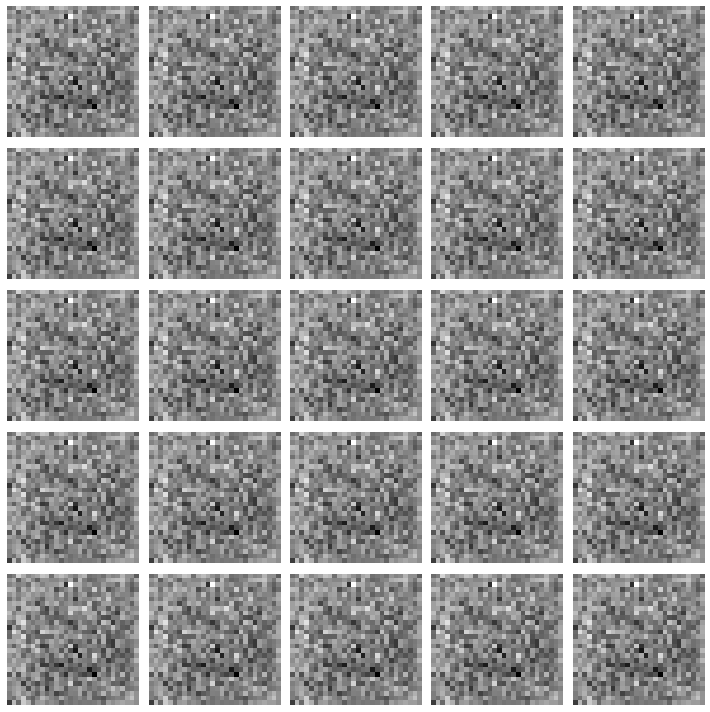

--------------- 
Epoch 8
-----------------------------------------------

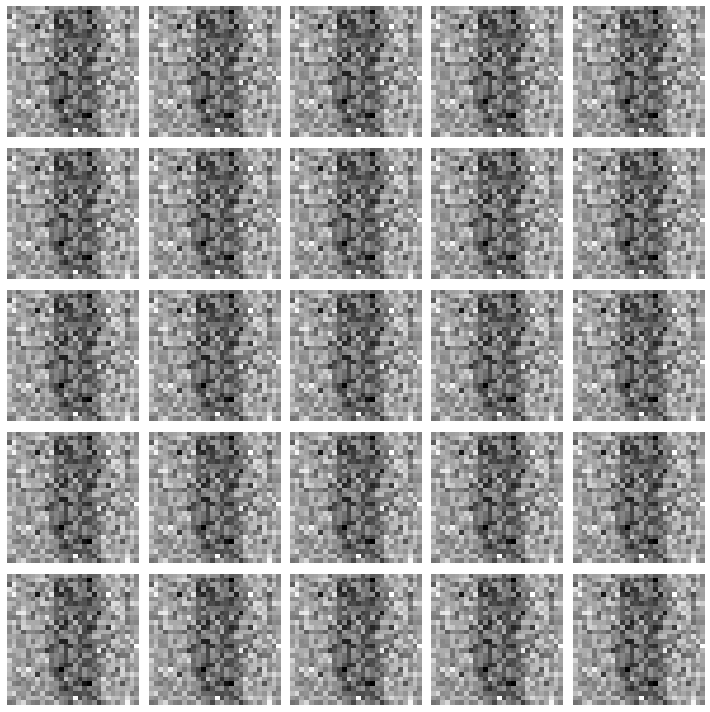

--------------- 
Epoch 9
-----------------------------------------------

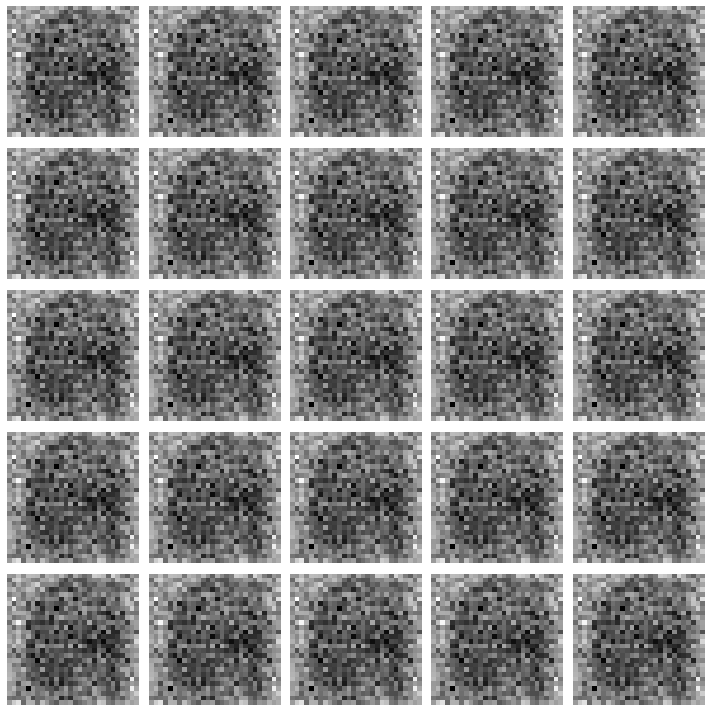

--------------- 
Epoch 10
-----------------------------------------------

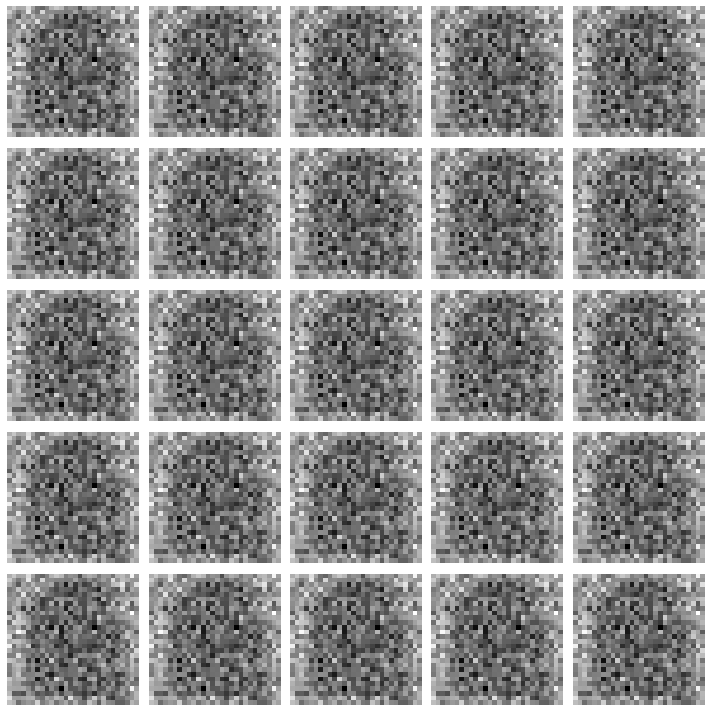

--------------- 
Epoch 11
-----------------------------------------------

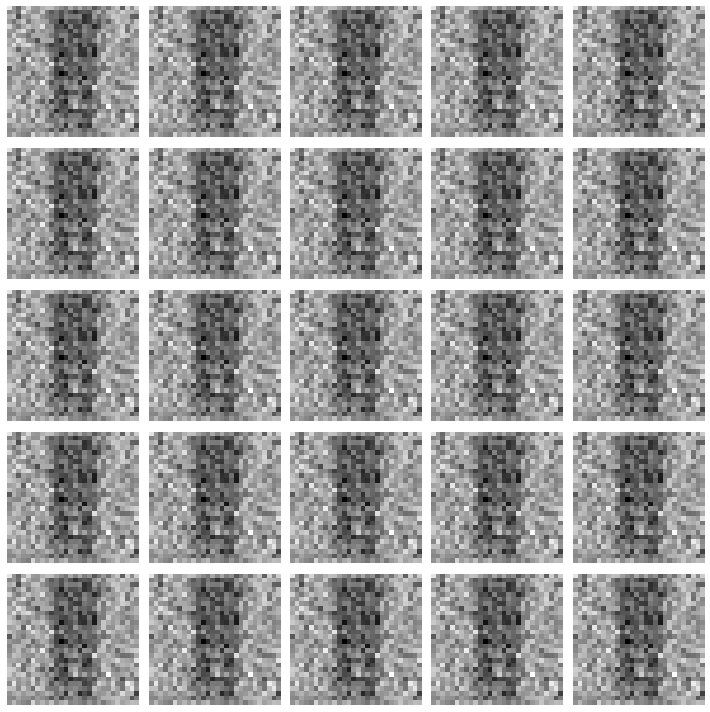

--------------- 
Epoch 12
-----------------------------------------------

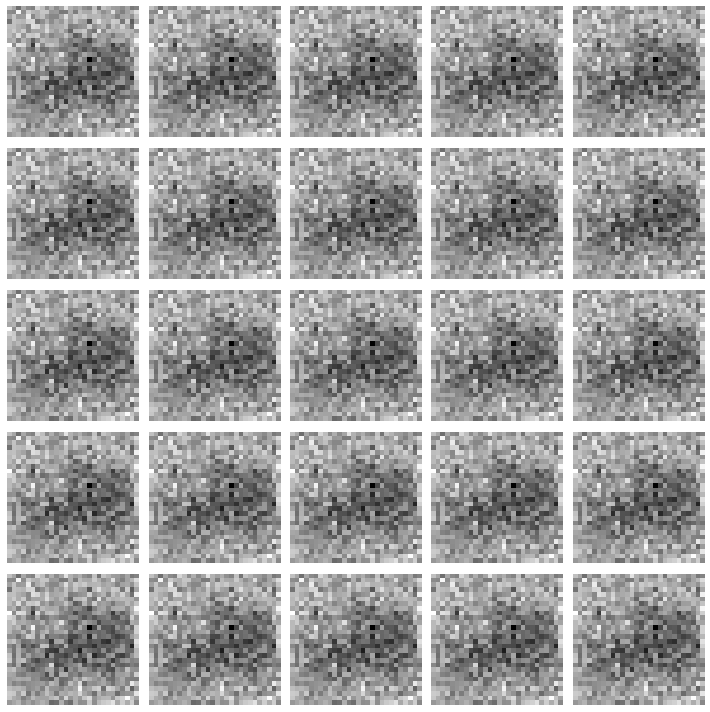

--------------- 
Epoch 13
-----------------------------------------------

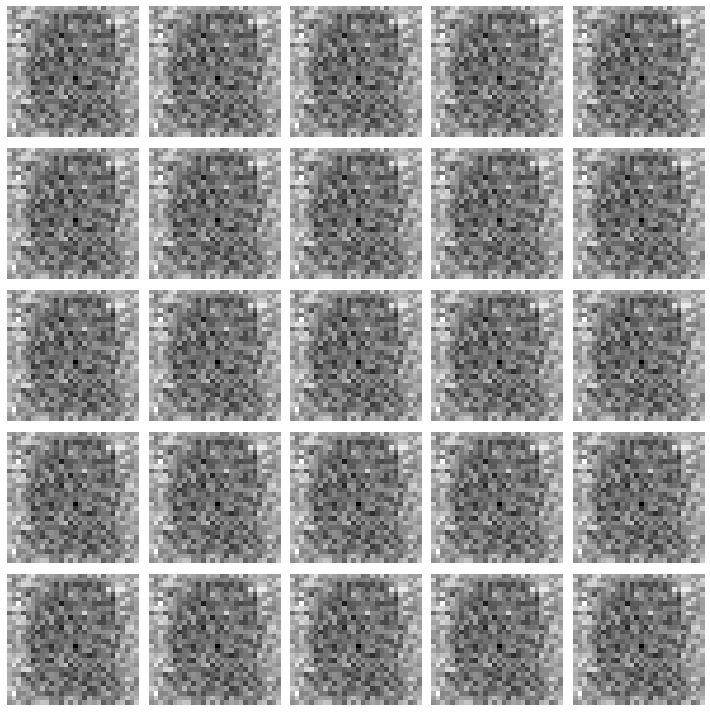

--------------- 
Epoch 14
-----------------------------------------------

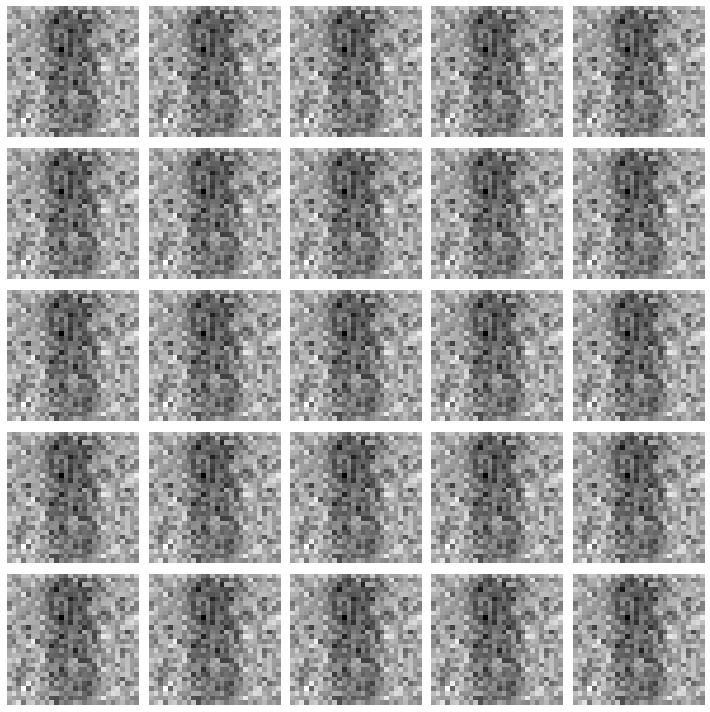

--------------- 
Epoch 15
-----------------------------------------------

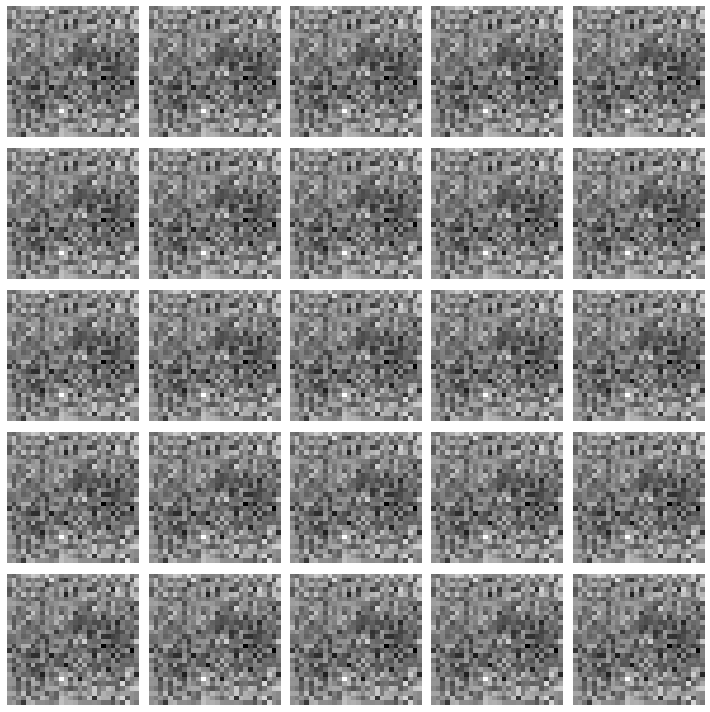

--------------- 
Epoch 16
-----------------------------------------------

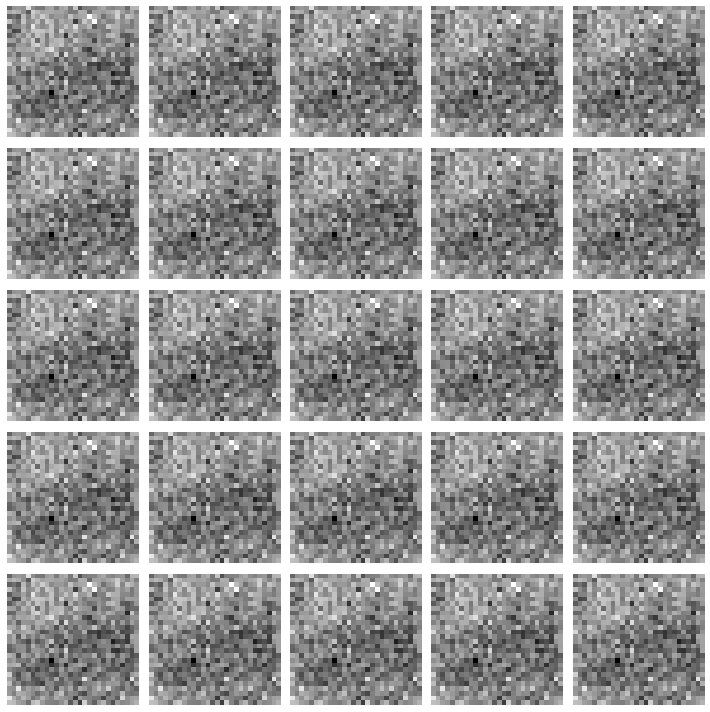

--------------- 
Epoch 17
-----------------------------------------------

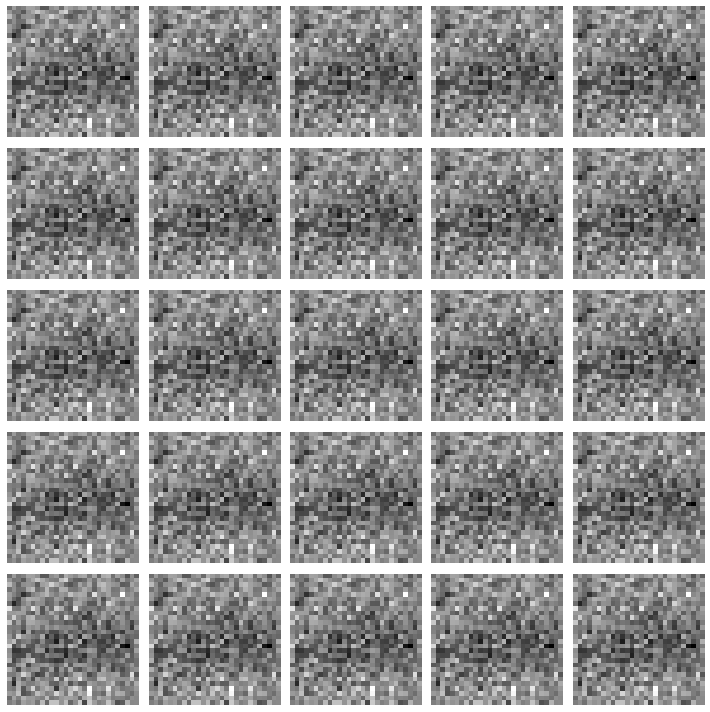

--------------- 
Epoch 18
-----------------------------------------------

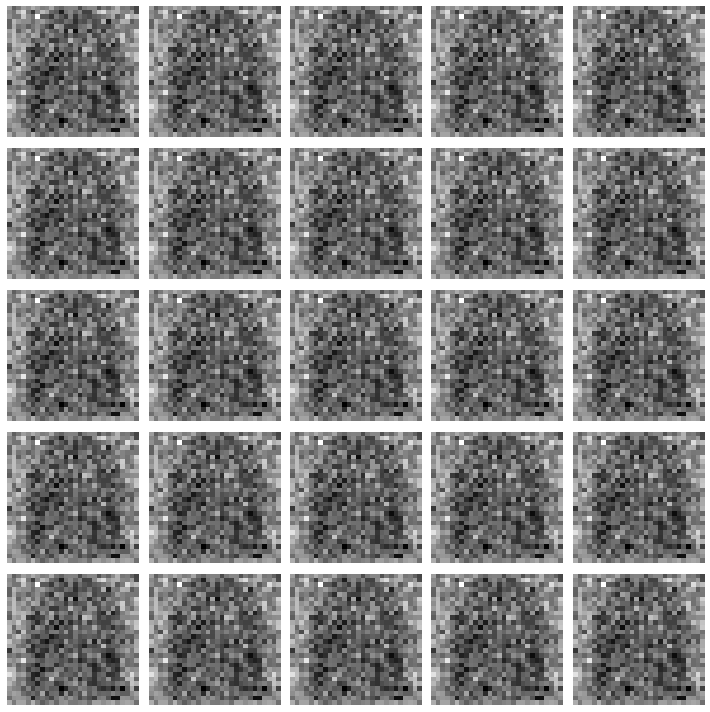

--------------- 
Epoch 19
-----------------------------------------------

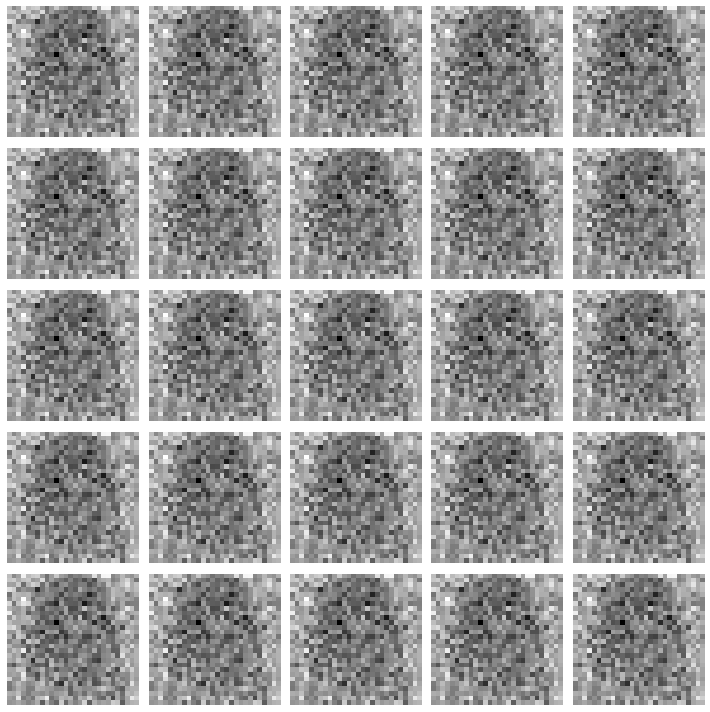

--------------- 
Epoch 20
-----------------------------------------------

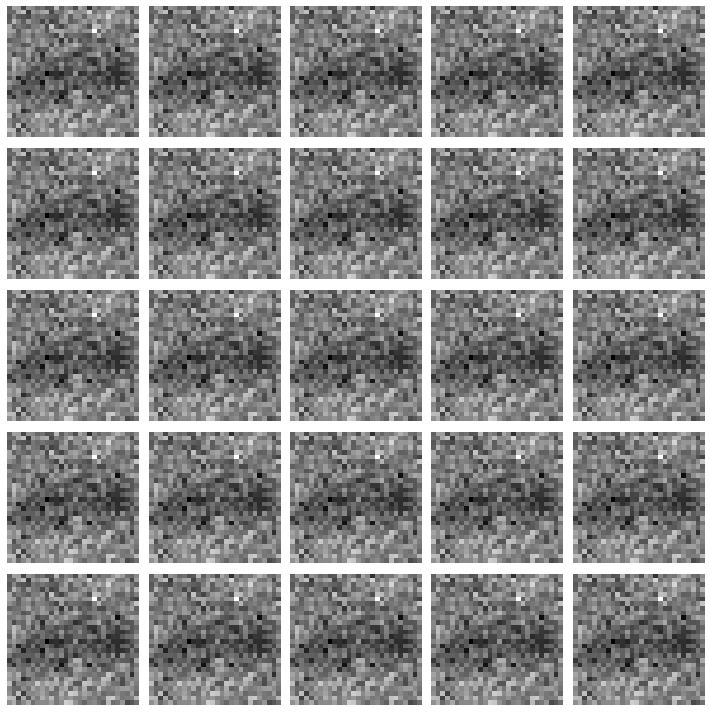

--------------- 
Epoch 21
-----------------------------------------------

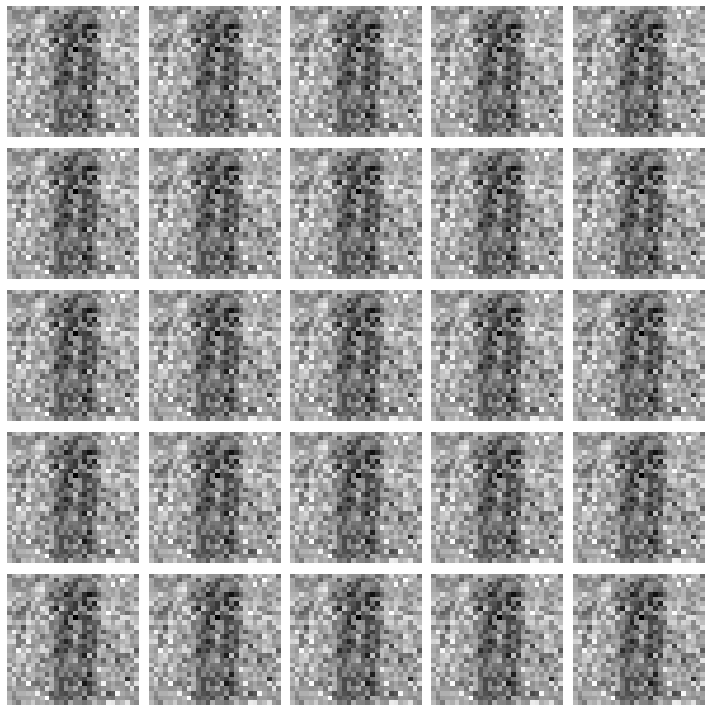

--------------- 
Epoch 22
-----------------------------------------------

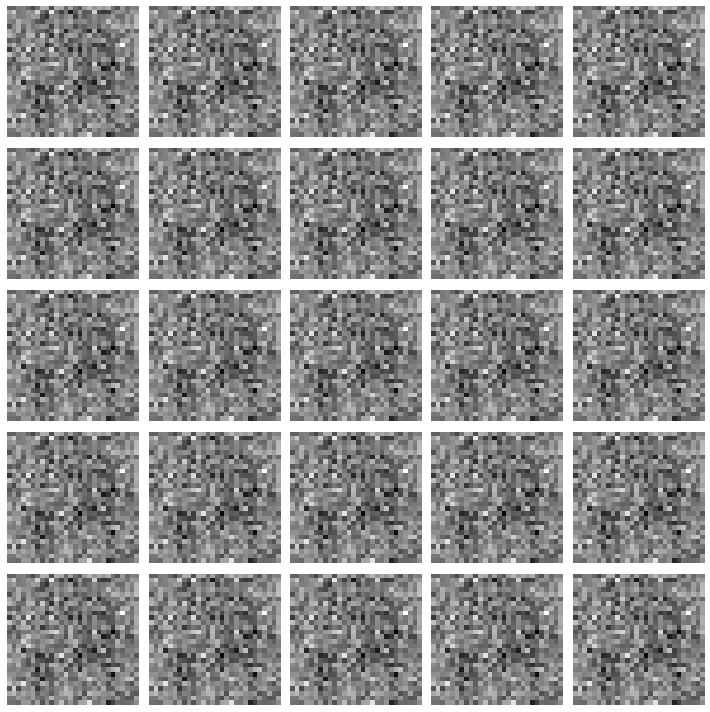

--------------- 
Epoch 23
-----------------------------------------------

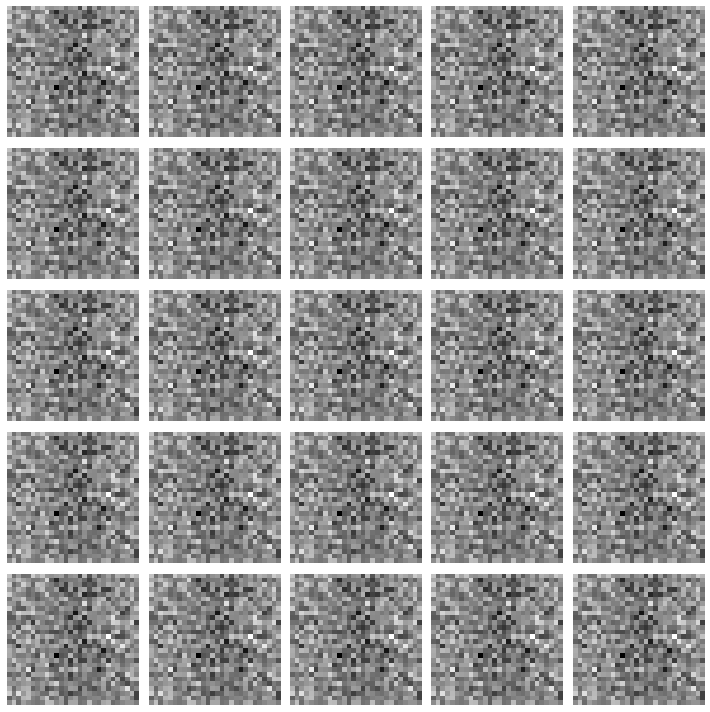

--------------- 
Epoch 24
-----------------------------------------------

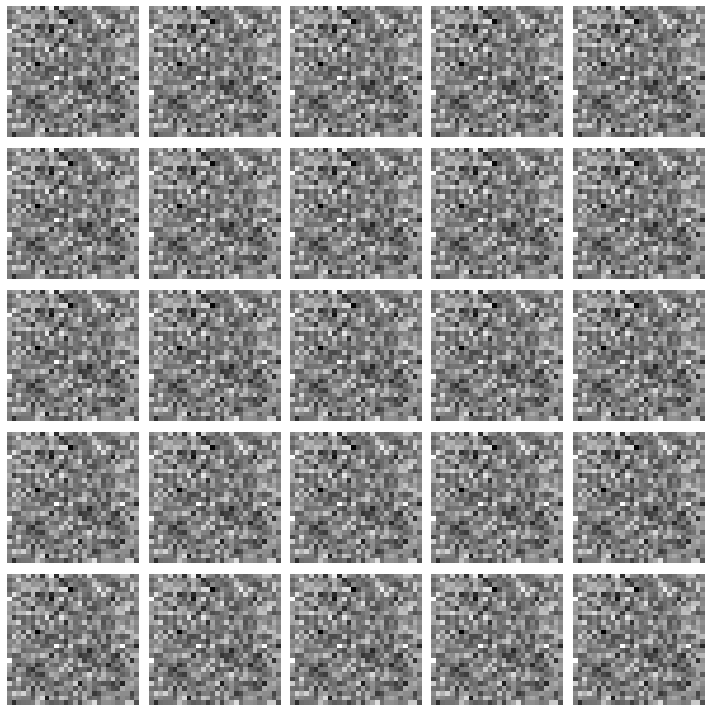

--------------- 
Epoch 25
-----------------------------------------------

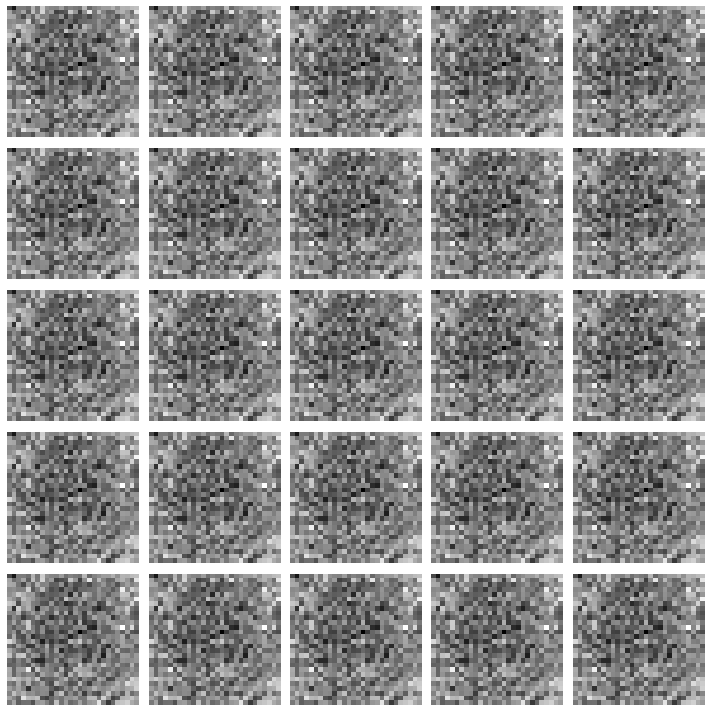

--------------- 
Epoch 26
-----------------------------------------------

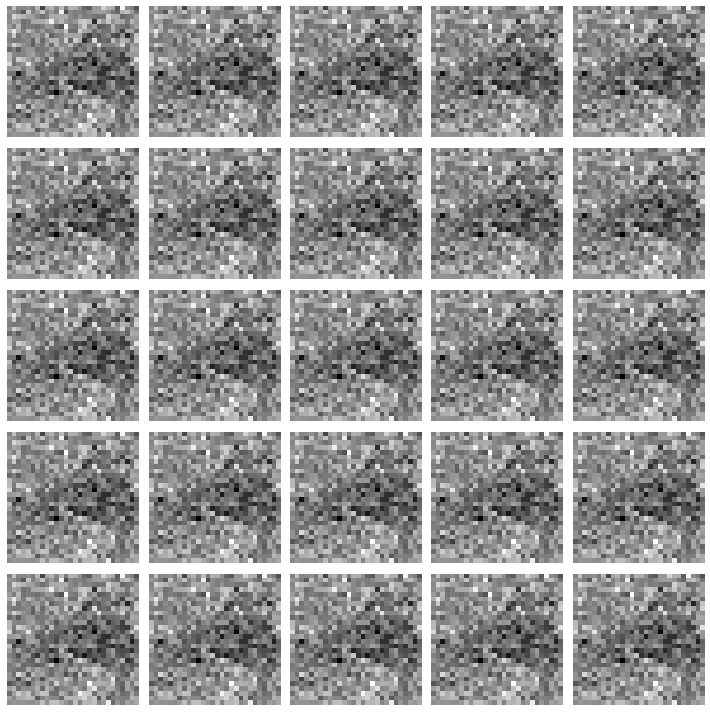

--------------- 
Epoch 27
-----------------------------------------------

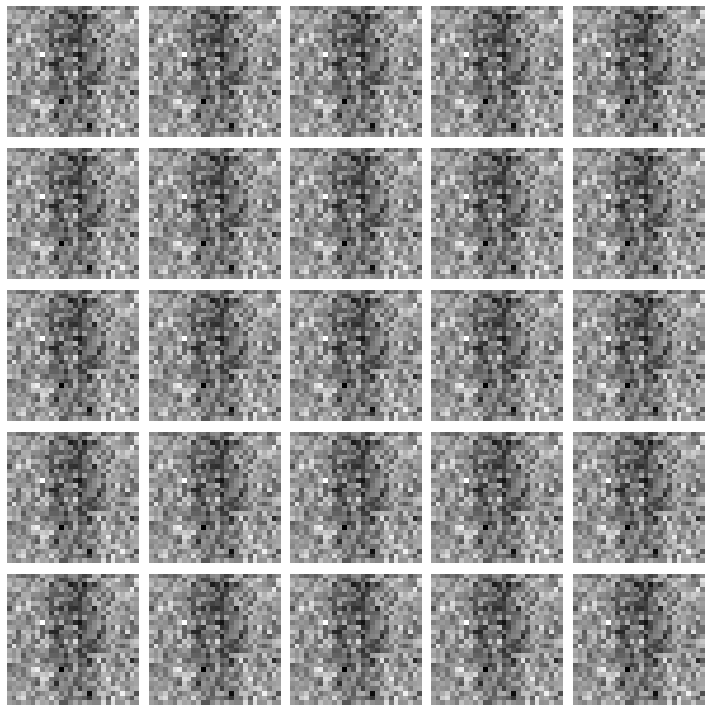

--------------- 
Epoch 28
-----------------------------------------------

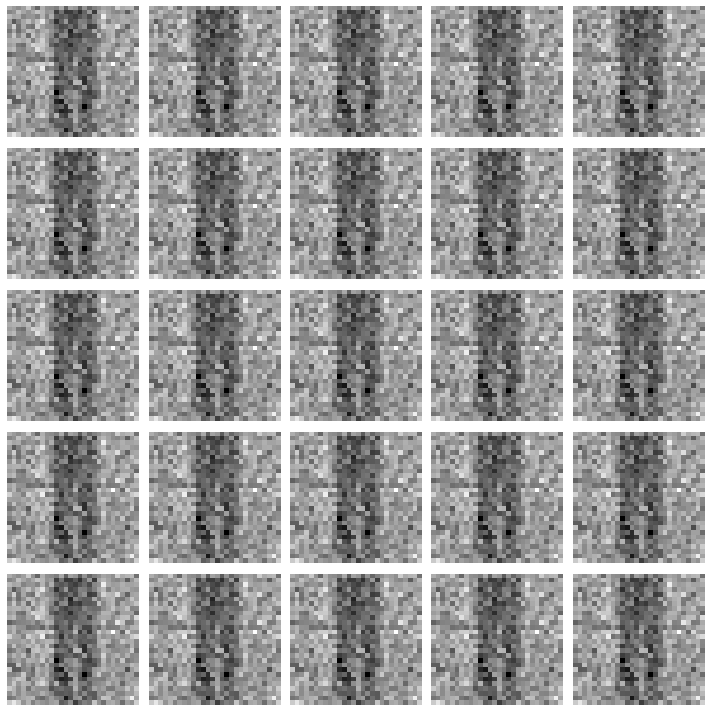

--------------- 
Epoch 29
-----------------------------------------------

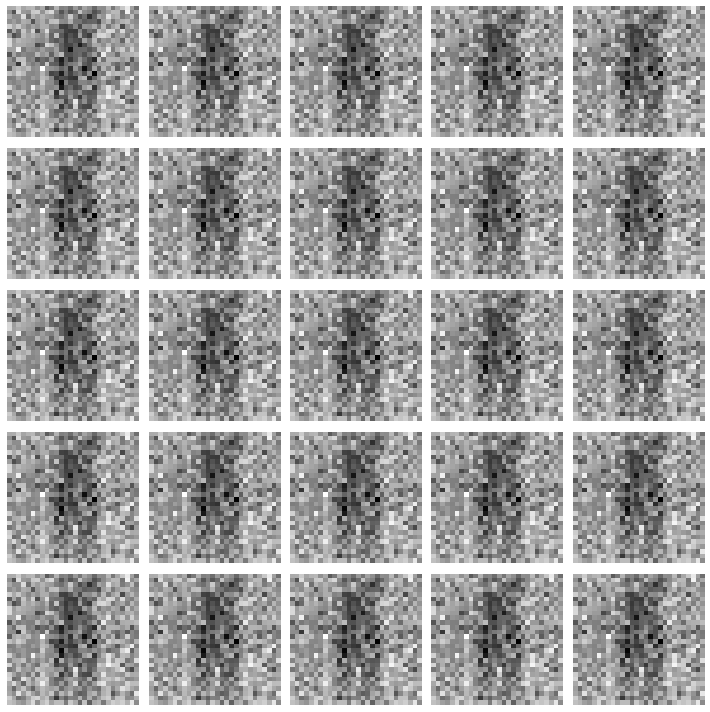

--------------- 
Epoch 30
-----------------------------------------------

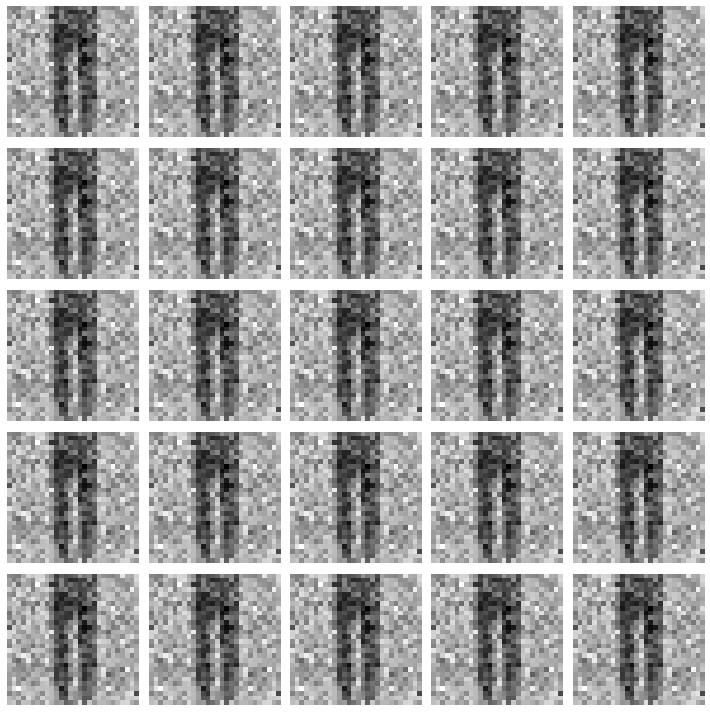

--------------- 
Epoch 31
-----------------------------------------------

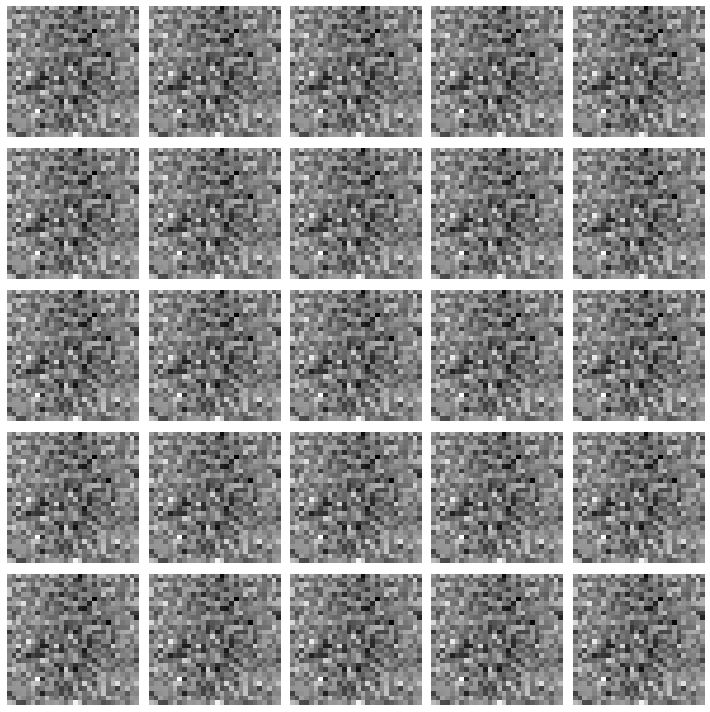

--------------- 
Epoch 32
-----------------------------------------------

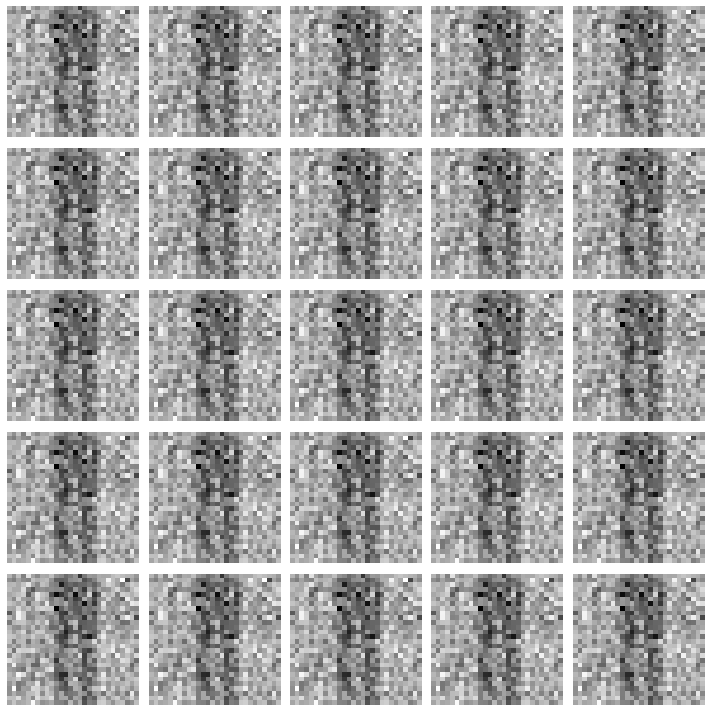

--------------- 
Epoch 33
-----------------------------------------------

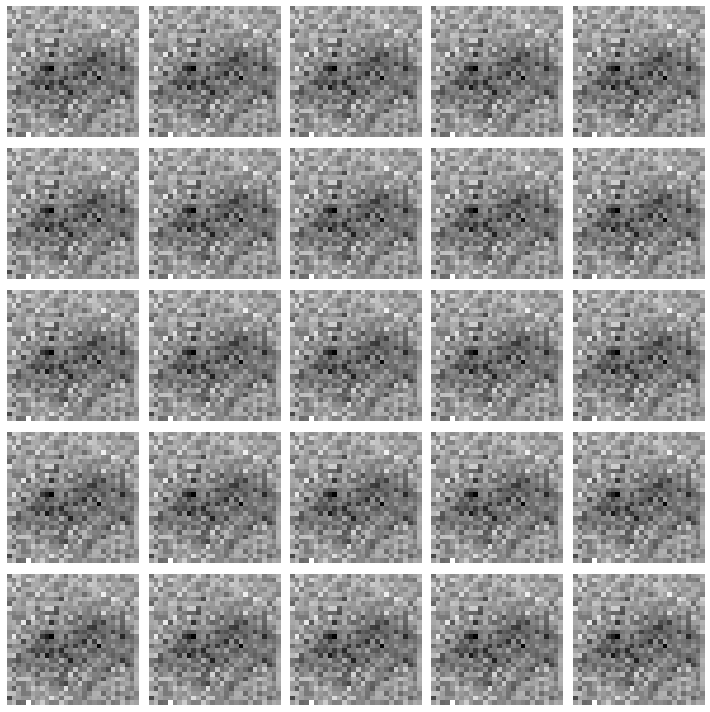

--------------- 
Epoch 34
-----------------------------------------------

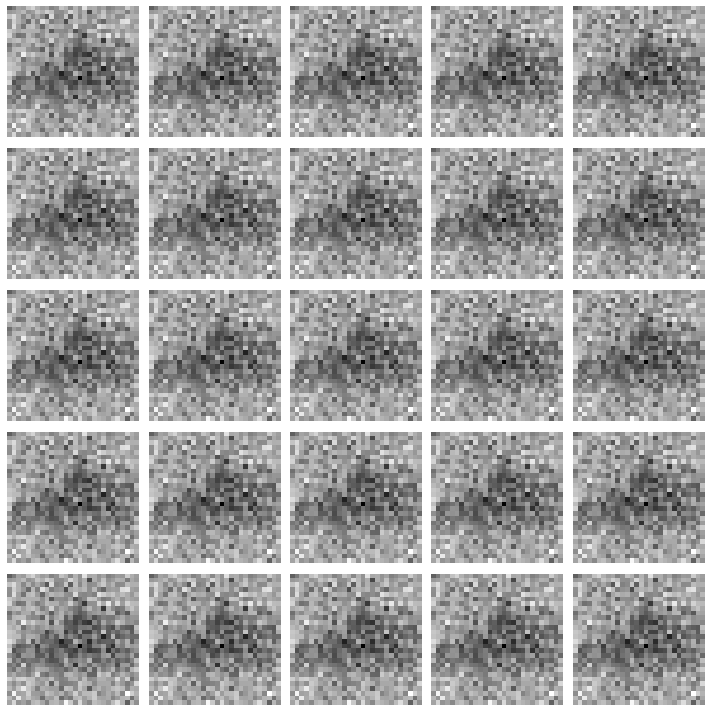

--------------- 
Epoch 35
-----------------------------------------------

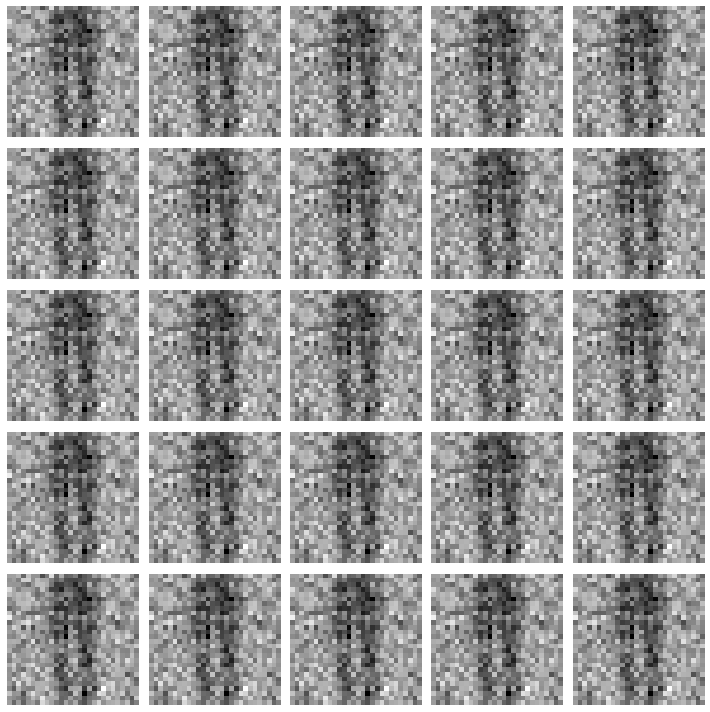

--------------- 
Epoch 36
-----------------------------------------------

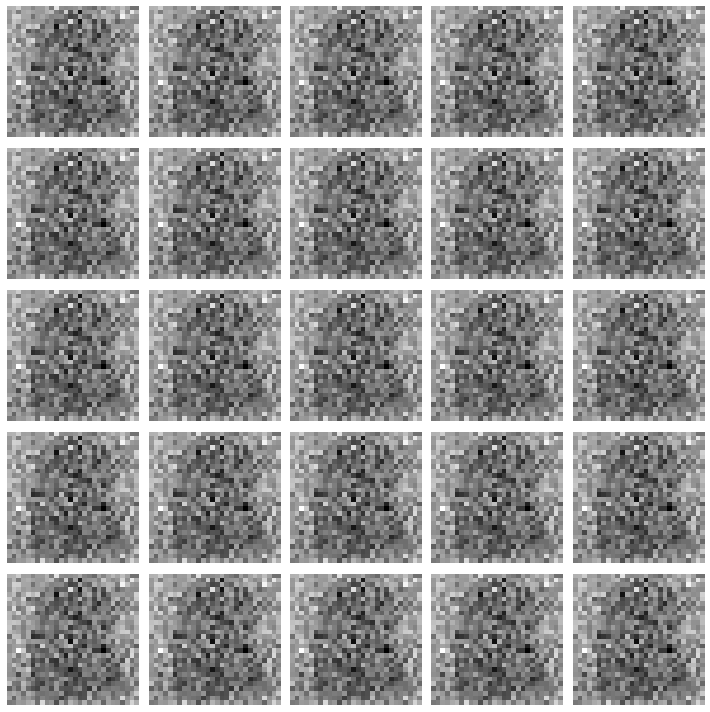

--------------- 
Epoch 37
-----------------------------------------------

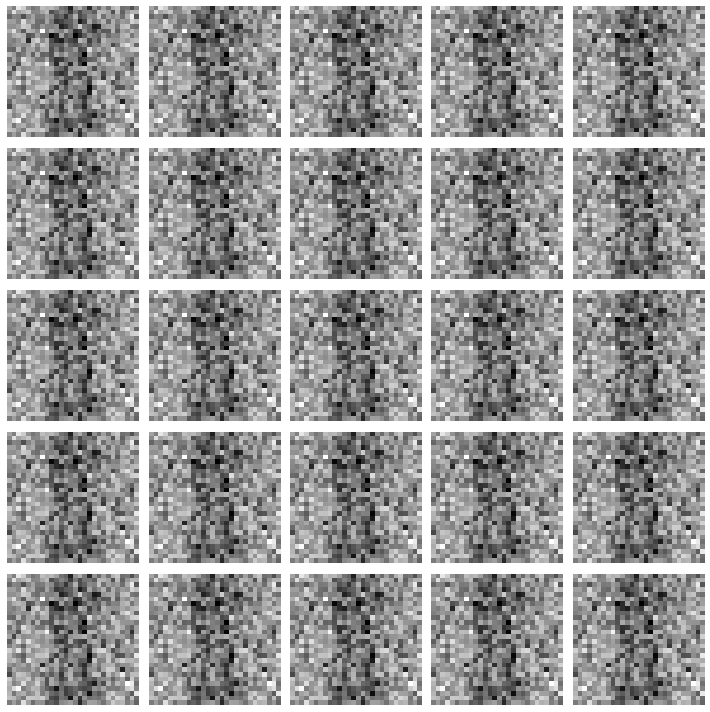

--------------- 
Epoch 38
-----------------------------------------------

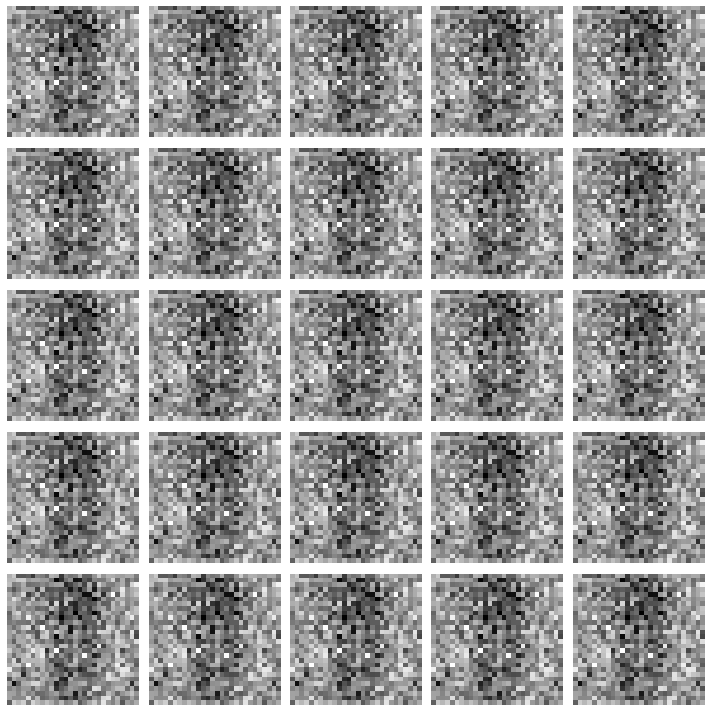

--------------- 
Epoch 39
-----------------------------------------------

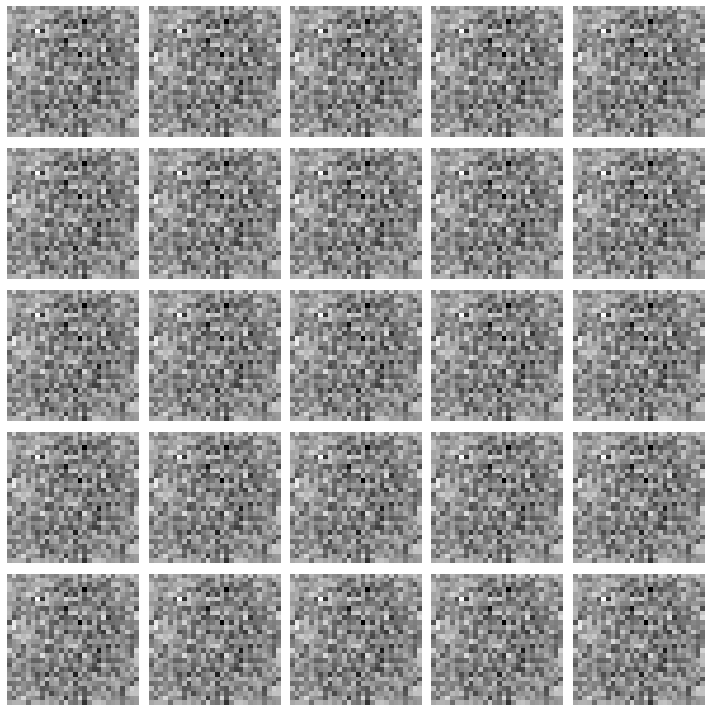

--------------- 
Epoch 40
-----------------------------------------------

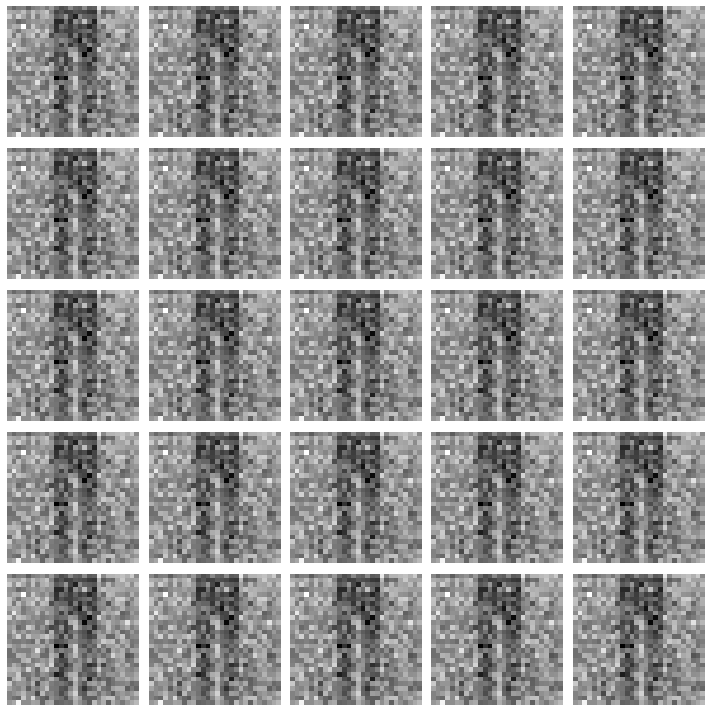

In [30]:
# 20회 반복 또는 epoch 훈련 
train(40)